# ECS708P mini-project submission

The mini-project consists of two components:


1.   **Basic solution** [6 marks]: Using the MLEnd dataset, build a model that predicts the intonation of a short audio segment.
2.   **Advanced solution** [10 marks]: There are two options. (i) Formulate a machine learning problem that can be attempted using the MLEnd dataset and build a solution model (e.g. identify a numeral in a short sequence). (ii) Create a product that uses the functionality provided by a model trained on the MLEnd dataset (e.g. identify a number based on the identification of individual numerals).  

The submission will consist of a single Jupyter notebook for both basic and advanced solution. The uploaded notebook should contain: 

*   **Text cells**, describing concisely each step and results.
*   **Code cells**, implementing each step.
*   **Output cells**, i.e. the output from each code cell.

and should have **two separate sections** for the basic and the advanced solutions.

What should you include in your notebook?

*   Title, student name, student ID.
*   Brief summary.
*   Dataset preparation.
*   Dataset visualisation.
*   Preprocessing.
*   Model(s) description.
*   Training and validation tasks.
*   Performance evaluation (accuracy, confusion matrix, ROC curve, etc).
*   Conclusions.


How will we evaluate your submission?

*   Conciseness in your writing (10%).
*   Correctness in your methodology (30%).
*   Correctness in your analysis and conclusions (30%).
*   Completeness (10%).
*   Originality (10%).
*   Efforts to try something new (10%).

Suggestion: Why don't you use **GitHub** to manage your project? GitHub can be used as a presentation card that showcases what you have done and gives evidence of your data science skills, knowledge and experience. 


# 1 Basic solution


# Intonation Prediction Project
---
### Amaan Abdullah
### ID: 210244263

#Problem Definition & Summary
---

Can we use audio features extracted from the MLEnd dataset to predict the various intonations? We will attempt to achieve this using a variety of models, employing k-folds cross validation techniques to aid in choosing the best model for each architecture. These chosen models will then be trained using the full dataset to allow comparison of various performance metrics in order to select the optimal model to solve our problem.

For future analysis, we could try extracting other features to see if they might perform even better with the various model architectures. We could possibly even try more sophisticated model architectures (such as neural networks) although their performance may depend on other chosen features to be extracted from the MLEnd dataset.

# Environment set up
---

In this section we will set up a Colab environment for the MLEnd mini-project, following these steps: 

1.   Go to https://drive.google.com/
2.   Create a folder named 'Data' in 'MyDrive'. On the left, click 'New' > 'Folder', enter the name 'Data', and click 'create'
3.   Open the 'Data' folder and create a folder named 'MLEnd'.
4.   Move the file 'trainingMLEnd.csv' to the newly created folder 'MyDrive/Data/MLEnd'.



In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as stats

import os, sys, re, pickle, glob
import urllib.request
import zipfile

#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
drive.mount('/content/drive')

Mounted at /content/drive


Run the following cell to check that the MLEnd folder contains the file 'trainingMLEnd.csv':

In [ ]:
path = '/content/drive/MyDrive/Data/MLEnd'
os.listdir(path)

['trainingMLEnd.csv', 'training', 'training.zip']

# Data download
---

In this section we will download the data that we need to build our solutions. Note that we keep a separate dataset for testing purposes, which will kept hidden.

First, we will define a function that will allow us to download a file into a chosen location.

In [ ]:
def download_url(url, save_path):
    with urllib.request.urlopen(url) as dl_file:
        with open(save_path, 'wb') as out_file:
            out_file.write(dl_file.read())

The next step is to download the file 'training.zip' into the folder 'MyDrive/Data/MLEnd'. Note that this might take a while.

In [ ]:
url  = "https://collect.qmul.ac.uk/down?t=6H8231DQL1NGDI9A/613DLM2R3OFV5EEH9INK2OG"
save_path = '/content/drive/MyDrive/Data/MLEnd/training.zip'
download_url(url, save_path)

In [ ]:
directory_to_extract_to = '/content/drive/MyDrive/Data/MLEnd/training/'
with zipfile.ZipFile(save_path, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

Once this step is completed, you should have all the audio files in the location 'MyDrive/Data/MLEnd/training/training'. 

# Understanding our dataset
---

Let's check how many audio files we have in our training dataset:

In [ ]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
len(files)

19999

This figure (20k) corresponds to the number of **items** or **samples** in our dataset. Let's listen to some random audio files:

In [ ]:
# five random files
for _ in range(5):
  n = np.random.randint(20000)
  display(ipd.Audio(files[n]))

Here we check that we can identify the numeral and intonation.

Let's now load the contents of 'trainingMLEnd.csv' into a pandas DataFrame and explore them:

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')
labels

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


This file consists of 20k rows and 4 columns. Each row corresponds to one of the items in our dataset, and each item is described by four attributes:


1.   File ID (audio file)
2.   Numeral
3.   Participand ID
4.   Intonation


Next we will check how many items we have per numeral, per individual and per intonation to evaluate the distribution of the data.

In [ ]:
# Number of items per numeral

items_per_num = []
num_unique = np.unique(labels["digit_label"])
c = 0

for i in num_unique:
  c = 0
  for j in labels["digit_label"]:
    if i == j:
      c += 1
  items_per_num.append(c)

items_per_numeral = pd.DataFrame({"Numerals":num_unique, "Item Count":items_per_num})

# Number of items per individual

items_per_indi = []
participants = np.unique(labels["participant"])
c=0

for i in participants:
  c = 0
  for j in labels["participant"]:
    if i == j:
      c += 1
  items_per_indi.append(c)

items_per_individual = pd.DataFrame({"Individual":participants, "Item Count":items_per_indi})

# Number of items per intonation

items_per_inton = []
intonations = np.unique(labels["intonation"])
c=0

for i in intonations:
  c = 0
  for j in labels["intonation"]:
    if i == j:
      c += 1
  items_per_inton.append(c)

items_per_intonation= pd.DataFrame({"Intonation":intonations, "Item Count":items_per_inton})


print("The dataframe containing items per numeral is:", items_per_intonation) 

print("The dataframe containing items per individual is:", items_per_individual) 

print("The dataframe containing items per digit label is:")
items_per_numeral

The dataframe containing items per numeral is:   Intonation  Item Count
0      bored        5000
1    excited        5000
2    neutral        5000
3   question        5000
The dataframe containing items per individual is:     Individual  Item Count
0           S1         111
1          S10         118
2         S100         150
3         S101         145
4         S102          66
..         ...         ...
179        S95         129
180        S96         133
181        S97         118
182        S98          35
183        S99         109

[184 rows x 2 columns]
The dataframe containing items per digit label is:


,Numerals,Item Count
0,0,655
1,1,663
2,2,652
3,3,650
4,4,641
5,5,650
6,6,668
7,7,638
8,8,653
9,9,663


We can see from the final dataframe that there is a fairly even spread of samples for the various numerals.

Since the whole purpose is to predict the intonations, will now examine the distribution of intonation samples as a barplot:

<BarContainer object of 4 artists>

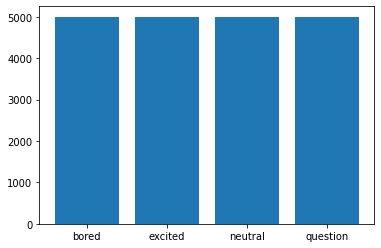

In [ ]:
# Bar plot of intonations
plt.bar(x=["bored","excited","neutral","question"], height=5000, width=0.8, bottom=None, align='center', data=items_per_intonation["Item Count"])

As we can see, the count for datasets per intonation is an even spread.

In the following cell we calculate the coefficient of variation for items per numeral and items per individual.

In [ ]:
import statistics as stats

cv_indi = stats.stdev(items_per_individual["Item Count"])/stats.mean(items_per_individual["Item Count"])
cv_num = stats.stdev(items_per_numeral["Item Count"])/stats.mean(items_per_numeral["Item Count"])

print("The coefficient of variation for items per individual is", cv_indi)
print("The coefficient of variation for items per numeral is", cv_num)

The coefficient of variation for items per individual is 0.3177649679612087
The coefficient of variation for items per numeral is 0.03958598644192974


The values of coefficient of variation are both suitably low for the purpose of solving this problem, therefore there is no need to transform the dataset in any way before moving onto the next stage.

One file "0012276.wav" was identified as containing data in an unkown format, so we will remove it before moving on to the feature extraction stage.

In [ ]:
path = '/content/drive/MyDrive/Data/MLEnd/training/Training/*'

if os.path.exists("0012276.wav"):
  os.remove("0012276.wav")
else:
  print("The file does not exist")

The file does not exist


# Feature Extraction : Pitch
---


Audio files are complex data types. Specifically they are **discrete signals** or **time series**, consisting of values on a 1D grid. These values are known as *samples* themselves, which might be a bit confusing, as we have used this term to refer to the *items* in our dataset. The **sampling frequency** is the rate at which samples in an audio file are produced. For instance a sampling frequency of 5HZ indicates that 5 produce 5 samples per second, or 1 sample every 0.2 s.

Let's plot one of our audio signals:

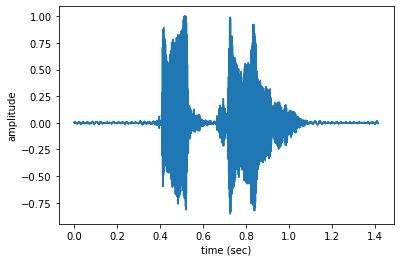

In [ ]:
n=2000
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

The file that we are listening to is:

In [ ]:
files[n]

'/content/drive/MyDrive/Data/MLEnd/training/Training/0002132.wav'

In [ ]:
labels.loc[labels["File ID"] == "0002132.wav"]

,File ID,digit_label,participant,intonation
2132,0002132.wav,15,S149,excited


From listening to the audio sample we can quite easily identify the numeral and inotation. Exactly, how complex is an audio signal? Let's start by looking at the number of samples in one of our audio files:

In [ ]:
n=2000
x, fs = librosa.load(files[n],sr=fs)
print('This audio signal has', len(x), 'samples')

This audio signal has 31232 samples


If we are using a raw audio signal as a predictor, we will be operating in a predictor space consisting of tens of thousands of dimensions. Comparing this figure with the number of samples that we have, we don't have enough samples to train a model that takes one of these audio signals as an input.

One approach is to extract a few features from our signals and use these features instead as predictors. In the following cell, we define a function that extracts four features from an audio signal, namely:


1.   Power.
2.   Pitch mean.
3.   Pitch standard deviation.
4.   Fraction of voiced region.

In the next cell, we define a new function that gets the pitch of an audio signal.

In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

Then next cell defines a function that takes a number of files and creates a NumPy array containing the 4 audio features used as predictors (`X`) and the itonations as their labels (`y`). 

In [ ]:
def getXy(files,labels_file,scale_audio=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]
    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    xi = [power,pitch_mean,pitch_std,voiced_fr]
    X.append(xi)
    y.append(yi)
  return np.array(X),np.array(y)

Let's apply `getXy` to all the audio files.


In [ ]:
X,y = getXy(files[:],labels_file=labels,scale_audio=True)


100%|██████████| 19999/19999 [3:20:30<00:00,  1.66it/s]


#Data Pre-Processing
---

The next cell shows the shape of `X` and `y` and prints the labels vector `y`:

In [ ]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (19999, 4)
The shape of y is (19999,)
The labels vector is ['bored' 'question' 'excited' ... 'bored' 'excited' 'bored']


Since we have a large number of samples, we will discard any possible items that are NaN rather than such methods as filling with the mean, mode or 0 etc.

In [ ]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
  idx = np.isnan(X).sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))

0


The following code saves the X and y datasets to csv files for use in later sessions.

In [ ]:
#np.savetxt("X_basic.csv", X, fmt='%5s', delimiter=',')
#np.savetxt("y_basic.csv", y, fmt='%5s', delimiter=',')

The next code line loads the csv files for the X and y datasets into numpy arrays to be used for modelling.

In [ ]:
# Loads datasets into numpy arrays
from numpy import genfromtxt

X = genfromtxt("X_basic.csv", delimiter=',')
y = pd.read_csv("y_basic.csv", delimiter=',', dtype=str, header=None)
y = np.array(y)
y = y[:,0]
y.shape

(19999,)

The following code takes the first 2000 samples from the feature dataset to be used for picking the best model. The full set can be left for training the final chosen models.

Since the data has no specific order, there is no need to randomise the selection of feature data.

In [ ]:
X_mod = X[:2000].astype('float')
X_mod.shape

(2000, 4)

We now need to encode the y label classes for the intonations to allow it to be fitted to the classification models.

In [ ]:
# label encoding for the target variable
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
y_enc = le.fit_transform(y)
y_mod = y_enc[:2000]

y_vs_ymod = pd.DataFrame(y[:20], y_mod[:20])
y_vs_ymod

,0
0,bored
3,question
1,excited
1,excited
3,question
1,excited
2,neutral
0,bored
2,neutral
2,neutral


The previous label has encoded the y labels as:
- Bored = 0
- Excited = 1
- Neutral = 2
- Question = 3

#Modelling
---

In order to maximise the predictive potential of the dataset, we will use k-folds cross validation for testing the models. This will allow us to use a significantly larger portion of the data for validating various model architectures compared to splitting the data into one validation and one training set; thereby reducing any chances of overfitting. We will choose a value of 20 k-folds as this seems sufficient for the size of the dataset and in fact, experimenting with various models whilst looping the number of folds gave optimal accuracy scores within the range of 10-19; so it would make sense to use the upper end and round the value.




We will also standardise the X feature values so that the model does not give more significance to one feature than the other due to differences in scale. For this we will use SciKit's StandardScaler function and create a pipeline to standardise the X feature values at each k-fold to ensure there is no data leakage. If the whole set was standardised before modelling, we would incur data leakage due to the splits which take place during modelling.

##KNN

We will firstly apply cross-validation to KNN classifier for different number of neighbours, K. A K value of 1 would be the highest level of overfitting to the training data and would generally make the model poor at predicting new data. Higher K values make the model more genralistic but could suffer from underfitting if the value is too high, thus also leading to poor accuracy scores.





In [ ]:
from sklearn import neighbors

k = np.linspace(2, 40, 39).astype(int)
knn_score_mean = np.zeros(39)

for count, i in enumerate(k):
  scalar = StandardScaler()
  knn = neighbors.KNeighborsClassifier(n_neighbors=i)
  pipeline = Pipeline([('transformer', scalar), ('estimator', knn)])

  K = KFold(n_splits=20)
  scores = cross_val_score(pipeline, X_mod, y_mod, cv = K)
  knn_score_mean[count] = scores.mean()


knn_score_mean 

array([0.4205, 0.4485, 0.459 , 0.461 , 0.471 , 0.486 , 0.491 , 0.495 ,
       0.4935, 0.489 , 0.493 , 0.487 , 0.497 , 0.4965, 0.5   , 0.5005,
       0.5065, 0.4995, 0.5035, 0.5025, 0.503 , 0.5075, 0.5005, 0.4985,
       0.5015, 0.497 , 0.501 , 0.4965, 0.5005, 0.494 , 0.496 , 0.495 ,
       0.4945, 0.492 , 0.4945, 0.493 , 0.497 , 0.498 , 0.4935])

In the following cell we will check the number of K neighbours which gives the optimal score value.

In [ ]:
k_max = np.where(knn_score_mean == np.max(knn_score_mean))

print("The optimal value for K neighbours is", k[k_max[0][0]], "giving a highest score of", np.max(knn_score_mean)) 

The optimal value for K neighbours is 23 giving a highest score of 0.5075000000000001


We will now plot the accuracy score for different values of K to make sure we are choosing the optimal K value.

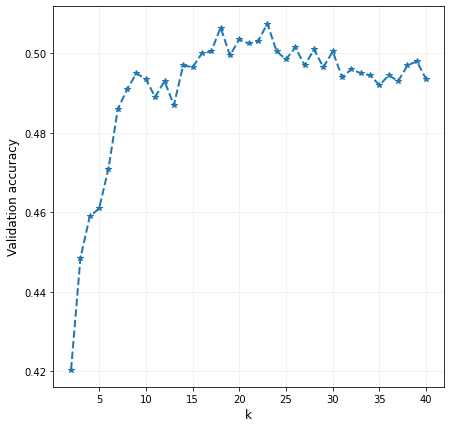

In [ ]:
# Here we predict the value of the validation accuracy as a function of k
plt.figure(figsize=(7, 7))
plt.plot(k, knn_score_mean, '--*', linewidth=2)
plt.xlabel("k", fontsize=12)
plt.ylabel("KNN Mean Accuracy Score", fontsize=12)
plt.grid(alpha=0.2)
plt.show()

We can see that we get an almost equally good accuracy score at K neighbours equal to 18, however we will stick to a K of 23 since the higher value means the model is better at generalising (less prone to overfiiting) and still gives a higher accuracy score.

Now that we have found the optimal K value and assessed the viability of the KNN model architecture using k-folds cross validation, we can now train a model using the full dataset and the found K value.

Firstly, we need to split the data into training and validation datasets so that the accuracy of the model can be assessed using data not used for building said model. We also need to standardise the feature data as we don't want the model to be overly sensitive to features which have naturally larger values thus masking the effect of features with naturally smaller values. It is important to standardise the data post split in order to avoid data leakage.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y_enc,test_size=0.25, random_state=40)

scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_val = scale.fit_transform(X_val)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((14999, 4), (5000, 4), (14999,), (5000,))

In the following cell we will fit the optimal KNN model and evaluate the training and validation accuracy metrics.

In [ ]:
from sklearn.metrics import confusion_matrix

knn_model = neighbors.KNeighborsClassifier(n_neighbors=23)
knn_model.fit(X_train, y_train)

yt_p = knn_model.predict(X_train)
yv_p = knn_model.predict(X_val)


print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.5863057537169145
Validation  Accuracy 0.5412


We can see that we have a validation accuracy of 0.541 which is a relatively small difference of ~0.045 from the training accuracy, indicating that the model has not suffered from overfitting.

##Support Vector Machines (SVM)

Next, we will apply cross-validation to Support Vector Machines modeling while varying the value of the C parameter. Decreasing C corresponds to more regularisation.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

c=[0.2, 0.4, 0.6, 0.8, 1, 2, 3, 4, 5]
svm_score_mean = np.zeros(9)

for count, i in enumerate(c):  
  scalar = StandardScaler()
  clf = svm.SVC(C=i)

  pipeline = Pipeline([('transformer', scalar), ('estimator', clf)])

  K = KFold(n_splits=20)
  scores = cross_val_score(pipeline, X_mod, y_mod, cv = K)
  svm_score_mean[count] = scores.mean()

svm_score_mean 

array([0.497 , 0.4965, 0.5095, 0.5095, 0.512 , 0.526 , 0.533 , 0.5335,
       0.5335])

We will now find the C value which gives the best score for SVM

In [ ]:
C_max = np.where(svm_score_mean == np.max(svm_score_mean))

print("The optimal C parameter is", c[C_max[0][0]], "giving a highest score of", np.max(svm_score_mean)) 

The optimal C parameter is 4 giving a highest score of 0.5335


In the following we will choose the optimal value for C based on visualisation. Instead of simply choosing the C value which gives the highest score, we will check where the elbow point lies, beyond which there is not a significant increase of score, however we would run into a risk of overfitting.

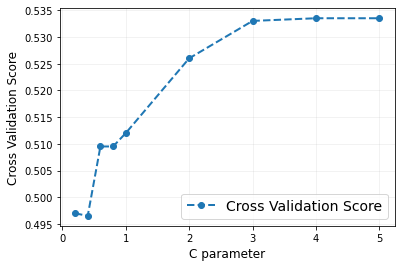

In [ ]:
plt.plot(c, svm_score_mean, '--o', label='Cross Validation Score', linewidth=2)

plt.xlabel("C parameter", fontsize=12)
plt.ylabel("Cross Validation Score", fontsize=12)
plt.grid(alpha=0.2)
plt.legend(fontsize=14)
plt.show()

In [ ]:
print("This shows that the optimal c value is 3, giving a cross validation score of", svm_score_mean[6])

This shows that the optimal c value is 3, giving a cross validation score of 0.533


We can see that the optimal value of C is 3, as there is no significant change beyond this value.

In the following cell, we will train a model using the previously split and scaled data and the optimal C parameter. We will then evaluate the training and validation accuracy and produce a confusion matrix to test it's ability to predict the various classes for intonation labels.

In [ ]:
svm_model  = svm.SVC(C=3)
svm_model.fit(X_train,y_train)

yt_p = svm_model.predict(X_train)
yv_p = svm_model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.553303553570238
Validation  Accuracy 0.5538


We can see that we have a validation accuracy of 0.554 which is almost exactly the same as the training accuracy, so the model has not suffered from overfitting at all.

##Logistic Regression

In the following we will apply cross validation to logistic regression which will be creating linear boundaries. The closer a sample is to the linear boundary, the higher the classifier's uncertainty.
We will also vary the C parameter, with smaller values corresponding to stronger regularisation.

In [ ]:
from sklearn.linear_model import LogisticRegression

C_log = [0.1, 0.5, 1, 10, 50, 100, 500, 1000, 2000, 5000, 10000]
lr_score_mean = np.zeros(11)

for count, i in enumerate(C_log):
  scalar = StandardScaler()
  lr = LogisticRegression(C=i, solver='lbfgs', multi_class='multinomial')
  pipeline = Pipeline([('transformer', scalar), ('estimator', lr)])

  K = KFold(n_splits=20)
  scores = cross_val_score(pipeline, X_mod, y_mod, cv = K)
  lr_score_mean[count] = scores.mean()

lr_score_mean

array([0.493 , 0.4945, 0.4935, 0.4925, 0.4925, 0.4925, 0.4925, 0.4925,
       0.4925, 0.4925, 0.4925])

We will now check the value of C which gives the optimal score.

In [ ]:
C_log_max = np.where(lr_score_mean == np.max(lr_score_mean))

print("The optimal C parameter is", C_log[C_log_max[0][0]], "giving score of", np.max(lr_score_mean))

The optimal C parameter is 0.5 giving score of 0.49450000000000005


The C parmeter giving the highest score is less than 1, so we know it is not prone to overfitting (high level of regularisation) and can say that this in fact the optimal value for C.

In the following cell, we will train a model using the previously split and scaled data and the optimal C parameter. We will then evaluate the training and validation accuracy and produce a confusion matrix to test it's ability to predict the various classes for intonation labels.

In [ ]:
lr_model  = lr = LogisticRegression(C=0.5, solver='lbfgs', multi_class='multinomial')
lr_model.fit(X_train,y_train)

yt_p = lr_model.predict(X_train)
yv_p = lr_model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.5118341222748183
Validation  Accuracy 0.5184


We can see that we have a validation accuracy of 0.518 which is a very slight advantage over the training accuracy, so the model has definitely not suffered from overfitting.

#Further Model Assessment
---

The use of k-folds cross validation on each of the model architectures has indicated that Support Vector Machines provide the best model architecture for our data.

Evaluating the predictive accuracy of the models has shown that SVM has also given the best validation accuracy of 0.554 although very close to that of KNN, giving a validation accuracy of 0.541.

Although all the metrics are pointing to the SVM model as being the best suited model for solving our problem, we will now dive a little deeper into this analysis by evaluating the confusion matrices of each model. This will tell us the capability of each model to predict each specific class label for intonations.

Let's firstly look at the confusion matrix for the KNN model.

In [ ]:
from sklearn.metrics import confusion_matrix

yt_p = knn_model.predict(X_train)
yv_p = knn_model.predict(X_val)


train_confusion_matrix = confusion_matrix(y_true=y_train, y_pred=knn_model.predict(X_train))
train_confusion_matrix_normalised = train_confusion_matrix.astype('float') / train_confusion_matrix.sum(axis=1)[:, np.newaxis]

val_confusion_matrix = confusion_matrix(y_true=y_val, y_pred=knn_model.predict(X_val))
val_confusion_matrix_normalised = val_confusion_matrix.astype('float') / val_confusion_matrix.sum(axis=1)[:, np.newaxis]

print('Training confusion matrix:\n {}\n'.format(train_confusion_matrix))
print('Validation confusion matrix:\n {}\n'.format(val_confusion_matrix))

print('Normalised training confusion matrix:\n {}\n'.format(train_confusion_matrix_normalised))
print('Normalised validation confusion matrix:\n {}\n'.format(val_confusion_matrix_normalised))

Training confusion matrix:
 [[2471  246  865  144]
 [ 251 2203  431  881]
 [1293  438 1721  295]
 [ 145  913  303 2399]]

Validation confusion matrix:
 [[754  95 379  45]
 [ 96 669 143 326]
 [445 173 533 102]
 [ 64 332  94 750]]

Normalised training confusion matrix:
 [[0.66317767 0.06602254 0.23215244 0.03864734]
 [0.06664896 0.58497079 0.11444503 0.23393521]
 [0.34507606 0.11689351 0.45930077 0.07872965]
 [0.03856383 0.24281915 0.08058511 0.63803191]]

Normalised validation confusion matrix:
 [[0.59230165 0.07462687 0.29772192 0.03534957]
 [0.07779579 0.54213938 0.11588331 0.26418152]
 [0.35514765 0.13806864 0.42537909 0.08140463]
 [0.0516129  0.26774194 0.07580645 0.60483871]]



From the normalised validation confusion matrix, we can see that the KNN model predicts the question intonation (label = 3) with highest accuracy of 0.605 and neutral with lowest accuracy of 0.425.

Now, let's look at the confusion matrix for the SVM model.

In [ ]:
yt_p = svm_model.predict(X_train)
yv_p = svm_model.predict(X_val)


train_confusion_matrix = confusion_matrix(y_true=y_train, y_pred=svm_model.predict(X_train))
train_confusion_matrix_normalised = train_confusion_matrix.astype('float') / train_confusion_matrix.sum(axis=1)[:, np.newaxis]

val_confusion_matrix = confusion_matrix(y_true=y_val, y_pred=svm_model.predict(X_val))
val_confusion_matrix_normalised = val_confusion_matrix.astype('float') / val_confusion_matrix.sum(axis=1)[:, np.newaxis]

print('Training confusion matrix:\n {}\n'.format(train_confusion_matrix))
print('Validation confusion matrix:\n {}\n'.format(val_confusion_matrix))

print('Normalised training confusion matrix:\n {}\n'.format(train_confusion_matrix_normalised))
print('Normalised validation confusion matrix:\n {}\n'.format(val_confusion_matrix_normalised))

Training confusion matrix:
 [[2304  233 1034  155]
 [ 188 1934  554 1090]
 [1388  397 1634  328]
 [ 127  864  342 2427]]

Validation confusion matrix:
 [[790  86 351  46]
 [ 64 622 182 366]
 [436 148 563 106]
 [ 56 278 112 794]]

Normalised training confusion matrix:
 [[0.61835749 0.06253355 0.27750939 0.04159957]
 [0.04992034 0.51354222 0.14710568 0.28943176]
 [0.37042968 0.10595143 0.4360822  0.0875367 ]
 [0.0337766  0.22978723 0.09095745 0.64547872]]

Normalised validation confusion matrix:
 [[0.6205813  0.06755695 0.27572663 0.03613511]
 [0.05186386 0.50405186 0.14748784 0.29659643]
 [0.34796488 0.11811652 0.44932163 0.08459697]
 [0.04516129 0.22419355 0.09032258 0.64032258]]



From the normalised validation confusion matrix, we can see that the SVM model predicts the question intonation with highest accuracy of 0.640 and neutral with lowest accuracy of 0.449.

Now let's look at the confusion matrix for the logistic regression model.

In [ ]:
yt_p = lr_model.predict(X_train)
yv_p = lr_model.predict(X_val)


train_confusion_matrix = confusion_matrix(y_true=y_train, y_pred=lr_model.predict(X_train))
train_confusion_matrix_normalised = train_confusion_matrix.astype('float') / train_confusion_matrix.sum(axis=1)[:, np.newaxis]

val_confusion_matrix = confusion_matrix(y_true=y_val, y_pred=lr_model.predict(X_val))
val_confusion_matrix_normalised = val_confusion_matrix.astype('float') / val_confusion_matrix.sum(axis=1)[:, np.newaxis]

print('Training confusion matrix:\n {}\n'.format(train_confusion_matrix))
print('Validation confusion matrix:\n {}\n'.format(val_confusion_matrix))

print('Normalised training confusion matrix:\n {}\n'.format(train_confusion_matrix_normalised))
print('Normalised validation confusion matrix:\n {}\n'.format(val_confusion_matrix_normalised))

Training confusion matrix:
 [[2441  211  925  149]
 [ 301 1568  754 1143]
 [1646  411 1404  286]
 [ 170  843  483 2264]]

Validation confusion matrix:
 [[827  78 332  36]
 [101 511 245 377]
 [514 150 493  96]
 [ 60 267 152 761]]

Normalised training confusion matrix:
 [[0.65512614 0.05662909 0.2482555  0.03998926]
 [0.07992565 0.41635688 0.20021243 0.30350505]
 [0.43928476 0.10968775 0.37469976 0.07632773]
 [0.04521277 0.22420213 0.12845745 0.60212766]]

Normalised validation confusion matrix:
 [[0.6496465  0.06127258 0.26080126 0.02827965]
 [0.08184765 0.41410049 0.19854133 0.30551053]
 [0.41021548 0.11971269 0.39345571 0.07661612]
 [0.0483871  0.21532258 0.12258065 0.61370968]]



From the normalised validation confusion matrix, we can see that the logistic regression model predicts the question intonation with highest accuracy of 0.614 and neutral with lowest accuracy of 0.393.

#Conclusions
---

Although we have seen from the normalised validation matrices that the KNN model is slightly better at predicting the excited intonation (0.542 vs 0.504), we can say that the SVM model is the best option overall for solving our problem.

Not only is it better at predicting the bored, neutral and question intonations, but it also has the highest overall validation accuracy (0.554 vs 0.541 and 0.518 for KNN and logistic regression respectively) as well as being indicated as the best suited architecture from k-folds cross validation assessment; where we used as much of the data as possible for assessing it's validity.

For future analysis, we could try extracting other features to see if they might perform even better with the various model architectures. We could possibly even try more sophisticated model architectures (such as neural networks) although their performance may depend on other chosen features to be extracted from the MLEnd dataset.

# 2 Advanced solution
---

### Amaan Abdullah
### ID: 210244263

#Problem Definition & Summary
---

Can we use audio features extracted from the MLEnd dataset to predict the various numerals in the dataset? We will attempt to do this using the data samples which have a neutral intonation. We will train various models using 2 different feature sets and compare various performance metrics to select the best approach to predicting the 32 different numeral class labels.

For future applications, we can see how a chosen model incorporating all the intonations compares to the chosen model for this project.

# Environment set up
---

In this section we will set up a Colab environment for the MLEnd mini-project, following these steps: 

1.   Go to https://drive.google.com/
2.   Create a folder named 'Data' in 'MyDrive'. On the left, click 'New' > 'Folder', enter the name 'Data', and click 'create'
3.   Open the 'Data' folder and create a folder named 'MLEnd'.
4.   Move the file 'trainingMLEnd.csv' to the newly created folder 'MyDrive/Data/MLEnd'.



In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as stats

import os, sys, re, pickle, glob
import urllib.request
import zipfile

#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
drive.mount('/content/drive')

Mounted at /content/drive


Run the following cell to check that the MLEnd folder contains the file 'trainingMLEnd.csv':

In [ ]:
path = '/content/drive/MyDrive/Data/MLEnd'
os.listdir(path)

['trainingMLEnd.csv', 'training', 'training.zip']

# Data download
---

In this section we will download the data that we need to build our solutions. Note that we keep a separate dataset for testing purposes, which will kept hidden.

First, we will define a function that will allow us to download a file into a chosen location.

In [ ]:
def download_url(url, save_path):
    with urllib.request.urlopen(url) as dl_file:
        with open(save_path, 'wb') as out_file:
            out_file.write(dl_file.read())

The next step is to download the file 'training.zip' into the folder 'MyDrive/Data/MLEnd'. Note that this might take a while.

In [ ]:
url  = "https://collect.qmul.ac.uk/down?t=6H8231DQL1NGDI9A/613DLM2R3OFV5EEH9INK2OG"
save_path = '/content/drive/MyDrive/Data/MLEnd/training.zip'
download_url(url, save_path)

Finally, let's unzip the training file.

In [ ]:
directory_to_extract_to = '/content/drive/MyDrive/Data/MLEnd/training/'
with zipfile.ZipFile(save_path, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

Once this step is completed, you should have all the audio files in the location 'MyDrive/Data/MLEnd/training/training'. 

# Understanding our dataset
---

Let's check how many audio files we have in our training dataset:

In [ ]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
len(files)

19999

This figure (20k) corresponds to the number of **items** or **samples** in our dataset. Let's listen to some random audio files:

In [ ]:
# five random files
for _ in range(5):
  n = np.random.randint(20000)
  display(ipd.Audio(files[n]))

Here we check that we can identify the numeral and intonation.

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')
labels

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


This file consists of 20k rows and 4 columns. Each row corresponds to one of the items in our dataset, and each item is described by four attributes:


1.   File ID (audio file)
2.   Numeral
3.   Participand ID
4.   Intonation

Let's now create a new dataframe for the audio files which have a neutral intonation

In [ ]:
labels_neutral = labels[labels["intonation"]=="neutral"].reset_index(drop=True)
labels_neutral

,File ID,digit_label,participant,intonation
0,0000002.wav,70,S5,neutral
1,0000006.wav,2,S136,neutral
2,0000014.wav,70,S7,neutral
3,0000015.wav,90,S102,neutral
4,0000018.wav,80,S95,neutral
...,...,...,...,...
4995,0019982.wav,50,S108,neutral
4996,0019983.wav,70,S129,neutral
4997,0019988.wav,11,S76,neutral
4998,0019998.wav,19,S13,neutral


We will now do a count for the number of datasets belonging to each participant and each digit label to evaluate the distribution of the dataset.

In [ ]:
# Number of items per individual

items_per_indi = []
participants = np.unique(labels_neutral["participant"])
c=0

for i in participants:
  c = 0
  for j in labels["participant"]:
    if i == j:
      c += 1
  items_per_indi.append(c)

items_per_individual = pd.DataFrame({"Individual":participants, "Item Count":items_per_indi})


# Number of items per numeral

items_per_num = []
num_unique = np.unique(labels_neutral["digit_label"])
c = 0

for i in num_unique:
  c = 0
  for j in labels_neutral["digit_label"]:
    if i == j:
      c += 1
  items_per_num.append(c)

items_per_numeral = pd.DataFrame({"Numerals":num_unique, "Item Count":items_per_num})

print("The dataframe for number of items per individual is", items_per_individual)
print("The dataframe for number of items per numeral is")
items_per_numeral

The dataframe for number of items per individual is     Individual  Item Count
0           S1         111
1          S10         118
2         S100         150
3         S101         145
4         S102          66
..         ...         ...
167        S94         134
168        S95         129
169        S96         133
170        S97         118
171        S99         109

[172 rows x 2 columns]
The dataframe for number of items per numeral is


,Numerals,Item Count
0,0,157
1,1,159
2,2,163
3,3,159
4,4,168
5,5,151
6,6,163
7,7,153
8,8,175
9,9,163


To further evaluate the distribution of the data, we will calculate the coefficient of variation for each item count.

In [ ]:
import statistics as stats

cv_indi = stats.stdev(items_per_individual["Item Count"])/stats.mean(items_per_individual["Item Count"])
cv_num = stats.stdev(items_per_numeral["Item Count"])/stats.mean(items_per_numeral["Item Count"])

print("The coefficient of variation for items per individual is", cv_indi)
print("The coefficient of variation for items per numeral is", cv_num)

The coefficient of variation for items per individual is 0.2698750843489603
The coefficient of variation for items per numeral is 0.05696568293506244


The coefficient of variation for items per individual is suitably low for the purpose of solving this problem. The COV for items per numeral also appears to be sufficiently low.

Since the problem we are trying to solve involves the identification of the numerals, we will take a closer look at the items per numeral by displaying the data visually. Let's create a bar plot to check the homogenity of the data in respect to count of items per numeral.

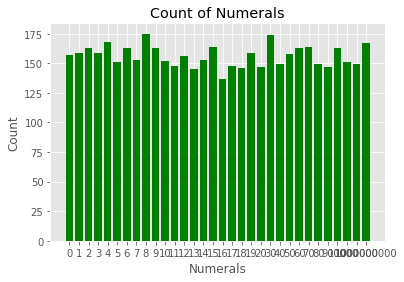

In [ ]:
%matplotlib inline
plt.style.use('ggplot')

x = np.transpose((items_per_numeral["Numerals"].astype("str")).tolist())
count = items_per_numeral["Item Count"]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, count, color='green')
plt.xlabel("Numerals")
plt.ylabel("Count")
plt.title("Count of Numerals")

plt.xticks(x_pos, x)

plt.show()

As we can see from the bar plot, the count for individual numerals is relatively homogeneous. Therefore there is no need to transform the data in any way in preparation for modelling.

# Feature Extraction : Pitch & Mel-Frequency Cepstral Coefficients (MFCC)
---

Audio files are complex data types. Specifically they are **discrete signals** or **time series**, consisting of values on a 1D grid. These values are known as *samples* themselves, which might be a bit confusing, as we have used this term to refer to the *items* in our dataset. The **sampling frequency** is the rate at which samples in an audio file are produced. For instance a sampling frequency of 5HZ indicates that 5 produce 5 samples per second, or 1 sample every 0.2 s.

Let's plot one of our audio signals:

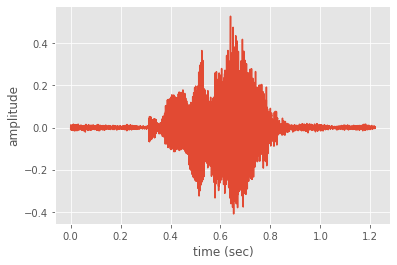

In [ ]:
n=0
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

The file that we are listening to is:

In [ ]:
files[n]

'/content/drive/MyDrive/Data/MLEnd/training/Training/0006970.wav'

From listening to the audio sample we can quite easily identify the numeral. Exactly, how complex is an audio signal? Let's start by looking at the number of samples in one of our audio files:

In [ ]:
n=0
x, fs = librosa.load(files[n],sr=fs)
print('This audio signal has', len(x), 'samples')

This audio signal has 26880 samples


If we are using a raw audio signal as a predictor, we will be operating in a predictor space consisting of tens of thousands of dimensions. Compare this figure with the number of samples that we have, we don't have enough samples to train a model that takes one of these audio signals as an input?

One approach is to extract a few features from our signals and use these features instead as predictors. In the following cells, we define a function that extracts five features from an audio signal, namely:


1.   Power.
2.   Pitch mean.
3.   Pitch standard deviation.
4.   Fraction of voiced region.
5.   Mel-Frequency Cepstral Coefficients (MFCC).

In the next cell, we define a new function that gets the pitch of an audio signal.

In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In the following cell we define a function that extracts the Mel-Frequency Cepstral Coefficients (MFCC) of an audio signal. This should be a useful feature as it can be used to visualise the spectrum of frequencies of a sound and how they vary over a very short time period. It is similar to a spectogram however instead of using a linear spaced frequency scale it in fact uses a quasi-logarithmic spaced frequency scale, which is more similar to the processing of sounds by the human auditory system.

In [ ]:
def extract_features(file):
   
    try:
        audio, sample_rate = librosa.load(file, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error while parsing file: ", file)
        return None 
     
    return mfccsscaled

Let's now consider the problem of identifying a numeral from the dataset. Then next cell defines a function that takes a number of files and creates a NumPy array containing the 5 audio features used as predictors (`X`) and the 32 numeral classes as their labels (`y`). 

In [ ]:
def getXy(files,labels_file,scale_audio=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1] 
    if fileID in labels_file['File ID'].values:
      yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
      
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)
        
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)
      mfccsscaled = extract_features(file)

      xi = [power,pitch_mean,pitch_std,voiced_fr,mfccsscaled]
      X.append(xi)
      y.append(yi)
    else: 
      continue
  return np.array(X),np.array(y)

Let's apply `getXy` to the files which have a neutral intonation.

In [ ]:
X,y = getXy(files[:],labels_file=labels_neutral,scale_audio=True)

# If you want to use all 20000 files, run next line instead
#X,y = getXy(files,labels_file=labels,scale_audio=True, onlySingleDigit=True)

100%|██████████| 19999/19999 [28:02<00:00, 11.89it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


The next cell shows the shape of `X` and `y` and prints the labels vector `y`:

In [ ]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (5000, 5)
The shape of y is (5000,)
The labels vector is [40  3 70 ...  9  4 30]


Finally, to be on the cautious side, let's eliminate any potential item with a NaN (*not a number*). First we will extract the first 4 features into an array as the 5th feature is a nested array consisting of 40 elements which represent the Mel-Frequency Cepstral Coefficients.

In [ ]:
X_4features = X[:,:4].astype('float')
# If nan sample, remove them
if np.sum(np.isnan(X_4features)):
  idx = np.isnan(X_4features).sum(1)>0
  X_4features = X_4features[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X_4features)))

0


The following code saves the extracted features and labels to separate csv files.

In [ ]:
#np.savetxt("X_advanced.csv", X, fmt='%5s', delimiter=',')
#np.savetxt("y_advanced.csv", y, fmt='%5s', delimiter=',')

Since the MFCC feature consists of 40 coefficients, we will split this from the rest of the features to be later modelled by a neural network architecture which is more suited to this type of data in terms of finding patterns as when applied to image classification. This is because the MFCC is akin to spectral imagery.

In [ ]:
X_mfcc = X[:,4]
#X_mfcc_new = []

#for arr in X_mfcc:
#  row = arr[:]
#  X_mfcc_new.append(row)

The following code saves the datasets in the previous cell to csv files.

In [ ]:
#np.savetxt("X_advanced_4features.csv", X_4features, fmt='%5s', delimiter=',')
#np.savetxt("X_advanced_mfcc.csv", X_mfcc_new, fmt='%5s', delimiter=',')

The following code loads the already created csv's into an array for use in later sessions.

In [ ]:
# Loads datasets into numpy arrays
from numpy import genfromtxt

y = genfromtxt("y_advanced.csv", delimiter=',').astype('int')
X_4features = genfromtxt("X_advanced_4features.csv", delimiter=',')
X_mfcc = genfromtxt("X_advanced_mfcc.csv", delimiter=',')

#Modelling
---

Here, we will explore various model architectures for the predictive task of identifying digits in an audio signal, using the datasets that we have just created.

##Decision Tree - Applied to first 4 features

A decision tree will come up with a set of decision rules at each level of leaf nodes which then splits the data at the next level, helping to further classify the data. A decision tree could be a good choice of model for the first 4 features, since the number of features is not too large for which to make decision rules. Therefore it should be less prone to overfitting as long as the right parameters are chosen; such as the maximum number of levels.

Firstly, we will split the dataset for the first 4 features into training and validation data, so that the various models can be assessed by accuracy metrics. We will then standardise the split data so that the model does not give more significance to one feature than the other due to differences in scale. For this we will use SciKit's StandardScaler function.

It is important to standardise the data after splitting into training and validation sets so we do not incur data leakage.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val = train_test_split(X_4features,y,test_size=0.25, random_state=40)

scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_val = scale.fit_transform(X_val)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((3750, 4), (1250, 4), (3750,), (1250,))

Now we will create multiple decision tree models whilst varying the maximum depth, and test the accuracy of each one to find the optimal decision tree.

In [ ]:
from sklearn import tree

max_depth = np.linspace(3, 30, 28)
training_accuracy = np.zeros(28)
validation_accuracy = np.zeros(28)

for count, i in enumerate(max_depth):
  clf = tree.DecisionTreeClassifier(max_depth=i)
  clf = clf.fit(X_train,y_train)
  yt_p = clf.predict(X_train)
  yv_p = clf.predict(X_val)
  training_accuracy[count] = np.mean(yt_p==y_train)
  validation_accuracy[count] = np.mean(yv_p==y_val)

train_acc_max = np.where(training_accuracy == np.max(training_accuracy))
val_acc_max = np.where(validation_accuracy == np.max(validation_accuracy))

print('Best training accuracy is at max depth =', max_depth[train_acc_max[0][0]], ', with accuracy =', np.max(training_accuracy))
print('Best validation accuracy is at max depth =', max_depth[val_acc_max[0][0]], ', with accuracy =', np.max(validation_accuracy))  


Best training accuracy is at max depth = 29.0 , with accuracy = 1.0
Best validation accuracy is at max depth = 7.0 , with accuracy = 0.0808


As we can see, the decision tree model validation accuracy for predicting numeral labels is a fairly low score of 0.0808.

The following plots a decsion tree for the best validation accuracy.

[Text(169.040021934896, 213.816, 'X[3] <= 0.059\ngini = 0.969\nsamples = 3750\nvalue = [125, 123, 118, 119, 139, 111, 120, 121, 123, 125\n108, 108, 115, 109, 113, 128, 101, 109, 112, 118\n114, 132, 109, 128, 117, 112, 116, 112, 117, 111\n113, 124]'),
 Text(55.02500817770547, 206.56799999999998, 'X[3] <= -1.261\ngini = 0.963\nsamples = 2029\nvalue = [74, 39, 79, 73, 95, 73, 118, 57, 102, 90, 89, 17\n74, 43, 28, 62, 72, 19, 30, 65, 81, 72, 58, 91\n102, 48, 54, 22, 64, 33, 22, 83]'),
 Text(11.55433449493121, 199.32, 'X[0] <= -1.442\ngini = 0.919\nsamples = 356\nvalue = [8, 2, 7, 7, 10, 10, 75, 8, 18, 23, 11, 1, 4\n3, 3, 8, 12, 6, 2, 11, 10, 5, 8, 23, 39, 4\n3, 1, 5, 3, 4, 22]'),
 Text(6.3284304851556845, 192.072, 'X[0] <= -1.53\ngini = 0.446\nsamples = 11\nvalue = [0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 1, 0, 0, 0\n0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0\n0, 0, 0, 0]'),
 Text(6.078177045619117, 184.824, 'X[2] <= -0.592\ngini = 0.5\nsamples = 2\nvalue = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0\n0

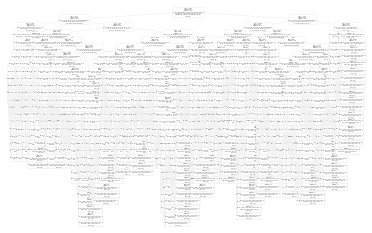

In [ ]:
tree.DecisionTreeClassifier(max_depth=15)
clf = clf.fit(X_train,y_train)
tree.plot_tree(clf) 

##Gaussian Naive Bayes - Applied to first 4 features

In the following cell, we will train a Gaussian Naive Bayes model. This model decouples the class conditional feature distributions which means that each distribution can be estimated independently as a one dimensional distribution. This helps to reduce issues that stem from the curse of dimensionality.

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb_model = gnb.fit(X_train, y_train)
y_pred = gnb_model.predict(X_val)

print("Number of mislabeled points out of a total %d points : %d" % (X_val.shape[0], (y_val != y_pred).sum()))
print("Accuracy =", 1 - ((y_val != y_pred).sum())/X_val.shape[0])

Number of mislabeled points out of a total 1250 points : 1144
Accuracy = 0.08479999999999999


As we can see, the Guassian Naive Bayes model validation accuracy for predicting numeral labels is a relatively low score of 0.0848.

## Support Vector Machines (SVM) - Applied to first 4 features



We will use the data from the first 4 features to train a model using SVM. We will vary the value of the C parameter to find the best performing model. Decreasing C corresponds to more regularisation hence less prone to overfitting.

In [ ]:
from sklearn import svm

c=[0.2, 0.4, 0.6, 0.8, 1, 2, 3, 4, 5]
training_accuracy_svm = np.zeros(9)
validation_accuracy_svm = np.zeros(9)

for count, i in enumerate(c):
  svm_model = svm.SVC(C=i)
  svm_model.fit(X_train,y_train)
  yt_p = svm_model.predict(X_train)
  yv_p = svm_model.predict(X_val)
  training_accuracy_svm[count] = np.mean(yt_p==y_train)
  validation_accuracy_svm[count] = np.mean(yv_p==y_val)

train_acc_max = np.where(training_accuracy_svm == np.max(training_accuracy_svm))
val_acc_max = np.where(validation_accuracy_svm == np.max(validation_accuracy_svm))

print('Best training accuracy is at C =', c[train_acc_max[0][0]], ', with accuracy =', np.max(training_accuracy_svm))
print('Best validation accuracy is at C =', c[val_acc_max[0][0]], ', with accuracy =', np.max(validation_accuracy_svm))  

   


Best training accuracy is at C = 5 , with accuracy = 0.15466666666666667
Best validation accuracy is at C = 1 , with accuracy = 0.088


As we can see, the SVM model validation accuracy for predicting numeral labels is a low score of 0.088.

##Multi-layer Perceptron Neural Network - Applied to MFCC feature set


As stated previously, neural networks are well suited to classifying imagery so should be well purposed to modelling the MFCC data which is a way of visually representing a sound wave. MLPs are a well established architecture for modelling neural networks so we will evaluate how this performs with our data.

It consists of three layers, including an input layer, a hidden layer and an output layer. We will use the dense layer type as this is popular for neural networks.

Firstly, we will need to encode the label data into a format that is readable for our neural networks model.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Encode the classification labels
le = LabelEncoder()
y_mod = to_categorical(le.fit_transform(y))

Before training the model, we must split the MFCC features into training and validation sets for later evaluation of accuracy metrics. Again, we will standardise the data post splitting to ensure there is no data leakage.

In [ ]:
# split the dataset 
from sklearn.model_selection import train_test_split 

X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_mfcc, y_mod, test_size=0.25, random_state = 40)

scale = StandardScaler()
X_train_nn = scale.fit_transform(X_train_nn)
X_val_nn = scale.fit_transform(X_val_nn)



- The first layer will be given the input shape of (1x40), corresponding to the number of MFFCs for each sample.
- The first two layers will have 300 nodes, using the Rectified Linear Activation function, as is known to work well with neural networks
- We will use a Dropout value of 40% on our initial two layers which randomly discards nodes from each update cycle. This is to help avoid overfitting and make the model better at generalising.
- The output layer has 32 nodes which is equal to the number of label classes.
- We will use the softmax activation for the ouput layer, as this makes an output summation of 1 and thus intrepetable as probabilities. This allows the model to use the highest probability as the basis for prediction.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_labels = y_mod.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

model.add(Dense(300, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

In the following cell we will compile the model.
- We will use the categorical_crossentropy for the loss function, as this is the most popular choice for classification. Higher performance is indicated by a lower score.
- We will use the accuracy metric as the performance metric which is determined with respect to the validation data.
- For the optimizer we will use adam as it is known to perform well in most cases.


In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(X_val_nn, y_val_nn, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 300)               12300     
_________________________________________________________________
activation_24 (Activation)   (None, 300)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 300)               90300     
_________________________________________________________________
activation_25 (Activation)   (None, 300)               0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)               

In the following cell we will train the model.
- We will use 80 epochs which corresponds to the number of times the model cycles through the data whilst improving each time.
- We will use a relatively low batch size of 30 as a large size can lead to overfitting.

In [ ]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 80
num_batch_size = 30

checkpointer = ModelCheckpoint(filepath='models/weights.best.mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train_nn, y_train_nn, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_val_nn, y_val_nn), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/80
125/125 [==============================] - 1s 5ms/step - loss: 1.0662 - accuracy: 0.6520 - val_loss: 2.6784 - val_accuracy: 0.2696

Epoch 00001: val_loss improved from inf to 2.67837, saving model to models/weights.best.mlp.hdf5
Epoch 2/80
125/125 [==============================] - 1s 4ms/step - loss: 1.0727 - accuracy: 0.6429 - val_loss: 2.6515 - val_accuracy: 0.2728

Epoch 00002: val_loss improved from 2.67837 to 2.65149, saving model to models/weights.best.mlp.hdf5
Epoch 3/80
125/125 [==============================] - 1s 4ms/step - loss: 1.0421 - accuracy: 0.6491 - val_loss: 2.6452 - val_accuracy: 0.2816

Epoch 00003: val_loss improved from 2.65149 to 2.64518, saving model to models/weights.best.mlp.hdf5
Epoch 4/80
125/125 [==============================] - 1s 4ms/step - loss: 1.0503 - accuracy: 0.6597 - val_loss: 2.6335 - val_accuracy: 0.2848

Epoch 00004: val_loss improved from 2.64518 to 2.63352, saving model to models/weights.best.mlp.hdf5
Epoch 5/80
125/125 [========

In the following cell we will evaluate the accuracy of the model for both the training and validation datasets.

In [ ]:
# Evaluating the model on the training and testing set
score = model.evaluate(X_train_nn, y_train_nn, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(X_val_nn, y_val_nn, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9976000189781189
Testing Accuracy:  0.29280000925064087


As we can see, the MLP neural network model validation accuracy for predicting numeral labels (using MFCC data) is a much better score of 0.293.

##Support Vector Machines (SVM) - Applied to MFCC feature set


Since the SVM model performed the best when applied to the first 4 features, we will see how this performs when applied to the MFCC dataset as a comparison to the MLP neural network model. In theory, this should not perform as well, as neural networks are known to perform well when applied to image classification, with MFCC being a visual representation of sound.

First we need to split the data into training and validation sets then standardise the data.

In [ ]:
# split the dataset 
from sklearn.model_selection import train_test_split 

X_train_svm, X_val_svm, y_train_svm, y_val_svm = train_test_split(X_mfcc, y, test_size=0.25, random_state = 40)

scale = StandardScaler()
X_train_svm = scale.fit_transform(X_train_svm)
X_val_svm = scale.fit_transform(X_val_svm)

In [ ]:
from sklearn import svm

c=[0.2, 0.4, 0.6, 0.8, 1, 2, 3, 4, 5]
training_accuracy_svm = np.zeros(9)
validation_accuracy_svm = np.zeros(9)

for count, i in enumerate(c):
  svm_model = svm.SVC(C=i)
  svm_model.fit(X_train_svm, y_train_svm)
  yt_p = svm_model.predict(X_train_svm)
  yv_p = svm_model.predict(X_val_svm)
  training_accuracy_svm[count] = np.mean(yt_p==y_train_svm)
  validation_accuracy_svm[count] = np.mean(yv_p==y_val_svm)

train_acc_max = np.where(training_accuracy_svm == np.max(training_accuracy_svm))
val_acc_max = np.where(validation_accuracy_svm == np.max(validation_accuracy_svm))

print('Best training accuracy is at max depth =', c[train_acc_max[0][0]], ', with accuracy =', np.max(training_accuracy_svm))
print('Best validation accuracy is at max depth =', c[val_acc_max[0][0]], ', with accuracy =', np.max(validation_accuracy_svm))  


Best training accuracy is at max depth = 5 , with accuracy = 0.9149333333333334
Best validation accuracy is at max depth = 5 , with accuracy = 0.2224


As we can see, the SVM model validation accuracy for predicting numeral labels, when applied to the MFCC feature, produces a score of 0.222. This is better than the score when applied to the first 4 features, however it does not perform as well as the MLP neural network model, as expected.

##Multi-layer Perceptron Neural Network - Original features


For completeness sake, we will now perform the same MLP neural network model on the orignal 4 features to show the comparison as when applied to the MFCC dataset. In theory, this should yield worse performance as it is believed that a well trained neural network model should produce relatively strong results when applied to a visual representation of sound as known to work well with image classification.

Firstly, we need to split the data into training and validation sets for the keras encoded label set and original 4 features. Then they again need to be standardised.

In [ ]:
# split the dataset 
from sklearn.model_selection import train_test_split 

X_train_mlp, X_val_mlp, y_train_mlp, y_val_mlp = train_test_split(X_4features, y_mod, test_size=0.25, random_state = 40)

scale = StandardScaler()
X_train_mlp = scale.fit_transform(X_train_mlp)
X_val_mlp = scale.fit_transform(X_val_mlp)

We will now build the model as before, but with input shape for the 4 features.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_labels = y_mod.shape[1]
filter_size = 2

# Construct model 
model_mlp = Sequential()

model_mlp.add(Dense(300, input_shape=(4,)))
model_mlp.add(Activation('relu'))
model_mlp.add(Dropout(0.4))

model_mlp.add(Dense(300))
model_mlp.add(Activation('relu'))
model_mlp.add(Dropout(0.4))

model_mlp.add(Dense(num_labels))
model_mlp.add(Activation('softmax'))

In the following cell we compile the model using the same theory as applied to the previous MLP model.

In [ ]:
# Compile the model
model_mlp.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
model_mlp.summary()

# Calculate pre-training accuracy 
score = model_mlp.evaluate(X_val_mlp, y_val_mlp, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 300)               1500      
_________________________________________________________________
activation_9 (Activation)    (None, 300)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 300)               90300     
_________________________________________________________________
activation_10 (Activation)   (None, 300)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)               

We now train the model using the same settings as applied previously.

In [ ]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 80
num_batch_size = 30

checkpointer = ModelCheckpoint(filepath='models/weights.best.mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model_mlp.fit(X_train_mlp, y_train_mlp, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_val_mlp, y_val_mlp), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/80
125/125 [==============================] - 1s 5ms/step - loss: 2.9631 - accuracy: 0.1429 - val_loss: 3.3878 - val_accuracy: 0.0720

Epoch 00001: val_loss improved from inf to 3.38782, saving model to models/weights.best.mlp.hdf5
Epoch 2/80
125/125 [==============================] - 1s 4ms/step - loss: 2.9654 - accuracy: 0.1397 - val_loss: 3.3825 - val_accuracy: 0.0768

Epoch 00002: val_loss improved from 3.38782 to 3.38247, saving model to models/weights.best.mlp.hdf5
Epoch 3/80
125/125 [==============================] - 1s 4ms/step - loss: 2.9643 - accuracy: 0.1376 - val_loss: 3.3884 - val_accuracy: 0.0760

Epoch 00003: val_loss did not improve from 3.38247
Epoch 4/80
125/125 [==============================] - 1s 4ms/step - loss: 2.9616 - accuracy: 0.1379 - val_loss: 3.3753 - val_accuracy: 0.0792

Epoch 00004: val_loss improved from 3.38247 to 3.37529, saving model to models/weights.best.mlp.hdf5
Epoch 5/80
125/125 [==============================] - 1s 4ms/step - loss: 2.96

In [ ]:
# Evaluating the model on the training and testing set
score = model_mlp.evaluate(X_train_mlp, y_train_mlp, verbose=0)
print("Training Accuracy: ", score[1])

score = model_mlp.evaluate(X_val_mlp, y_val_mlp, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.24346666038036346
Testing Accuracy:  0.08240000158548355


As we can see, the MLP neural network model validation accuracy for predicting numeral labels, when applied to the first 4 features dataset, produces a low score of 0.0824; which is a similar magnitude to the other models which were applied to the first 4 features.

#Further Model Assessment
---

Previously, we have seen that the MLP Neural Network model for MFCC data gave by far the best model validation accuracy compared to the other 3 models when applied to the power, pitch mean, pitch standard deviation and fraction of voiced region as feature sets.

We will dive a bit further into evaluating the performance of these various models by looking at confusion matrices for each one, thereby seeing how well they classify each of the numerals.

Let's firstly take a look at the confusion matrix for the decision tree model when applied to the first 4 features.

In [ ]:
from sklearn.metrics import confusion_matrix
import sys

np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(suppress=True,linewidth=np.nan)

yt_p = clf.predict(X_train)
yv_p = clf.predict(X_val)


train_confusion_matrix = confusion_matrix(y_true=y_train, y_pred=clf.predict(X_train))
train_confusion_matrix_normalised = train_confusion_matrix.astype('float') / train_confusion_matrix.sum(axis=1)[:, np.newaxis]

val_confusion_matrix = confusion_matrix(y_true=y_val, y_pred=clf.predict(X_val))
val_confusion_matrix_normalised = val_confusion_matrix.astype('float') / val_confusion_matrix.sum(axis=1)[:, np.newaxis]

print('Training confusion matrix:\n {}\n'.format(train_confusion_matrix))
print('Validation confusion matrix:\n {}\n'.format(val_confusion_matrix))

print('Normalised training confusion matrix:\n {}\n'.format(train_confusion_matrix_normalised))
print('Normalised validation confusion matrix:\n {}\n'.format(val_confusion_matrix_normalised))

Training confusion matrix:
 [[125   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 123   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 118   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 119   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 139   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 111   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 120   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 121   0   0   0   0   0  

For the decision tree model, the highest validation accuracy is for prediction of the 6 numeral with accuracy of 0.209. The majority of true predictions have an accuracy of less than 0.1 with numerous equal to 0. 

In the following cell we look at the confusion matrix for the Gaussian Naive Bayes model when applied to the first 4 features.

In [ ]:
yt_p = gnb_model.predict(X_train)
yv_p = gnb_model.predict(X_val)


train_confusion_matrix = confusion_matrix(y_true=y_train, y_pred=gnb_model.predict(X_train))
train_confusion_matrix_normalised = train_confusion_matrix.astype('float') / train_confusion_matrix.sum(axis=1)[:, np.newaxis]

val_confusion_matrix = confusion_matrix(y_true=y_val, y_pred=gnb_model.predict(X_val))
val_confusion_matrix_normalised = val_confusion_matrix.astype('float') / val_confusion_matrix.sum(axis=1)[:, np.newaxis]

print('Training confusion matrix:\n {}\n'.format(train_confusion_matrix))
print('Validation confusion matrix:\n {}\n'.format(val_confusion_matrix))

print('Normalised training confusion matrix:\n {}\n'.format(train_confusion_matrix_normalised))
print('Normalised validation confusion matrix:\n {}\n'.format(val_confusion_matrix_normalised))

Training confusion matrix:
 [[ 0  7  9  6 16  0 19  0  0 13 11  2  0  0  2  1  0  2  1  0  6  4  0  1  0  3  5  1  0  5 11  0]
 [ 0  6  7  2  8  0  8  0  0 18  8 11  0  0  6  1  0  8  1  0  1  3  0  0  0  4  7  1  0 12 11  0]
 [ 1  3 16  7 23  0 17  0  0 12  2  3  0  0  4  0  0  1  0  0  4  1  0  2  1  2  3  1  0  3 12  0]
 [ 0  8 14  6 18  0 19  0  0 11 12  2  0  0  5  0  0  2  0  0  4  1  0  0  0  1  3  1  0  6  6  0]
 [ 0  2 12 14 33  0 27  0  0 11 11  4  0  0  4  0  0  1  0  0  6  3  0  0  0  1  5  0  0  2  3  0]
 [ 0  1  3  1 13  0 20  0  0 16 22  0  0  0  1  0  0  3  0  0  8  6  0  0  1  2  5  1  0  6  2  0]
 [ 0  0  1  0  7  0 98  0  0  2  6  1  0  0  0  0  0  0  0  0  2  0  0  1  2  0  0  0  0  0  0  0]
 [ 0  5  5  2  6  0 14  0  0 17 25  4  0  0  6  0  0  4  1  0  3  0  0  0  1  7  8  0  0  9  4  0]
 [ 0  3  5  5 17  0 55  0  0  4 13  0  0  0  2  0  0  2  1  0  5  2  0  1  0  1  2  1  0  0  4  0]
 [ 0  3  1  0  8  0 42  0  0 13 24  2  0  0  4  0  0  2  0  0  7  2  0  0  1  4  

For the Gaussian Naive Bayes model, the highest validation accuracy is for prediction of the 6 numeral with accuracy of 0.837. However the majority of true predictions have an accuracy of less than 0.1 with numerous values of 0. 

Next we compute the confusion matrix for the SVM model when applied to the first 4 features.

In [ ]:
yt_p = svm_model.predict(X_train)
yv_p = svm_model.predict(X_val)


train_confusion_matrix = confusion_matrix(y_true=y_train, y_pred=svm_model.predict(X_train))
train_confusion_matrix_normalised = train_confusion_matrix.astype('float') / train_confusion_matrix.sum(axis=1)[:, np.newaxis]

val_confusion_matrix = confusion_matrix(y_true=y_val, y_pred=svm_model.predict(X_val))
val_confusion_matrix_normalised = val_confusion_matrix.astype('float') / val_confusion_matrix.sum(axis=1)[:, np.newaxis]

print('Training confusion matrix:\n {}\n'.format(train_confusion_matrix))
print('Validation confusion matrix:\n {}\n'.format(val_confusion_matrix))

print('Normalised training confusion matrix:\n {}\n'.format(train_confusion_matrix_normalised))
print('Normalised validation confusion matrix:\n {}\n'.format(val_confusion_matrix_normalised))

Training confusion matrix:
 [[14  2  7  1 28  5  5  2  2  2  5  5  3  7  2  1  0  3  3  0  4  6  0  0  1  0  3  3  0  2  5  4]
 [ 0 23  6  5  8  5  1  5  4  1  0  9  3  7  4  1  0 10  4  0  1  0  0  0  1  0  0  4  1  8  9  3]
 [ 1  3 22  8 36  3  7  0  0  2  0  2  5  3  1  1  0  2  4  0  1  2  0  0  3  1  0  1  0  2  4  4]
 [ 1  8 11  7 30  5  3  0  4  0  3  2  1  5  4  0  0  2  2  0  1  9  0  1  3  0  0  4  0  2  6  5]
 [ 6  5  4  6 53  7 10  1  3  0  2  4  2  5  7  1  0  1  0  0  0  4  0  1  2  0  0  1  0  3  3  8]
 [ 1 11  2  4  9 17  8  2  8  0  9  0  2  7  0  4  0  3  1  0  3  2  0  1  3  2  1  1  0  4  2  4]
 [ 0  0  0  0  9  1 82  0 10  2  2  0  1  2  1  0  0  0  1  0  2  2  0  0  4  0  0  0  0  0  0  1]
 [ 0  8  3  7 10  8  5  4  5  4  5  6  0  9  3  1  0  5  4  1  3  5  0  1  2  2  1  2  0 10  5  2]
 [ 0  3  2  4 26  4 12  1 31  3  6  0  1  7  1  1  0  0  1  0  1  2  0  1  4  0  1  1  0  0  5  5]
 [ 1  3  0  3 10  7  7  1 10 23 14  5  0  2  2  1  0  3  3  1  3  6  0  0  3  1  

For the SVM model, the highest validation accuracy is for prediction of the 6 numeral at an accuracy of 0.581 but the majority of true predictions are less than 0.1 and there are numerous values of 0. 

In the following cell we look at the confusion matrix for the MLP neural network model when applied to the MFCC feature set.

In [ ]:
yt_p = model.predict(X_train_nn)
yv_p = model.predict(X_val_nn)


train_confusion_matrix = confusion_matrix(y_true=y_train_nn.argmax(axis=1), y_pred=model.predict(X_train_nn).argmax(axis=1))
train_confusion_matrix_normalised = train_confusion_matrix.astype('float') / train_confusion_matrix.sum(axis=1)[:, np.newaxis]

val_confusion_matrix = confusion_matrix(y_true=y_val_nn.argmax(axis=1), y_pred=model.predict(X_val_nn).argmax(axis=1))
val_confusion_matrix_normalised = val_confusion_matrix.astype('float') / val_confusion_matrix.sum(axis=1)[:, np.newaxis]

print('Training confusion matrix:\n {}\n'.format(train_confusion_matrix))
print('Validation confusion matrix:\n {}\n'.format(val_confusion_matrix))

print('Normalised training confusion matrix:\n {}\n'.format(train_confusion_matrix_normalised))
print('Normalised validation confusion matrix:\n {}\n'.format(val_confusion_matrix_normalised))

Training confusion matrix:
 [[125   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1 121   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 118   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 119   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 139   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 111   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 120   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 121   0   0   0   0   0  

For the MLP model (MFCC), the highest validation accuracy is for prediction of the 4 numeral at an accuracy of 0.724, however for this model, there are also many other true predictions of similar magnitude with most being above at least 0.2. So far, this is by far the best performace we have seen.

Now we will look at the confusion matrix for the SVM model when applied to the MFCC feature set.

In [ ]:
yt_p = svm_model.predict(X_train_svm)
yv_p = svm_model.predict(X_val_svm)


train_confusion_matrix = confusion_matrix(y_true=y_train_svm, y_pred=svm_model.predict(X_train_svm))
train_confusion_matrix_normalised = train_confusion_matrix.astype('float') / train_confusion_matrix.sum(axis=1)[:, np.newaxis]

val_confusion_matrix = confusion_matrix(y_true=y_val_svm, y_pred=svm_model.predict(X_val_svm))
val_confusion_matrix_normalised = val_confusion_matrix.astype('float') / val_confusion_matrix.sum(axis=1)[:, np.newaxis]

print('Training confusion matrix:\n {}\n'.format(train_confusion_matrix))
print('Validation confusion matrix:\n {}\n'.format(val_confusion_matrix))

print('Normalised training confusion matrix:\n {}\n'.format(train_confusion_matrix_normalised))
print('Normalised validation confusion matrix:\n {}\n'.format(val_confusion_matrix_normalised))

Training confusion matrix:
 [[115   0   0   0   1   0   0   0   0   0   2   0   0   0   0   0   0   0   0   1   2   0   0   0   0   0   0   0   2   0   0   2]
 [  0 120   1   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1]
 [  0   0 112   1   1   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   1   0   0   0   0   1   0   0   0   0   0   0]
 [  2   1   0 102   0   0   0   0   1   1   0   0   0   1   0   0   0   0   0   1   4   1   0   0   0   0   0   1   1   0   0   3]
 [  0   0   0   0 138   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  2   0   0   0   1 104   0   1   0   0   0   0   1   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0 118   0   1   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   3 114   0   0   0   0   0  

For the SVM model (applied to MFCCs), the highest validation accuracy is for prediction of the 4 numeral at an accuracy of 0.655 with the majority of true predictions having a score greater than 0.2. This is a much better performance than the SVM model which was trained on the data from the first 4 features but not as good as the neural network model.

Lastly, lets look at the confusion matrix for the MLP model when applied to the dataset for the first 4 features.

In [ ]:
from sklearn.metrics import confusion_matrix
import sys

np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(suppress=True,linewidth=np.nan)

yt_p = model.predict(X_train_mlp)
yv_p = model.predict(X_val_mlp)


train_confusion_matrix = confusion_matrix(y_true=y_train_mlp.argmax(axis=1), y_pred=model.predict(X_train_mlp).argmax(axis=1))
train_confusion_matrix_normalised = train_confusion_matrix.astype('float') / train_confusion_matrix.sum(axis=1)[:, np.newaxis]

val_confusion_matrix = confusion_matrix(y_true=y_val_mlp.argmax(axis=1), y_pred=model.predict(X_val_mlp).argmax(axis=1))
val_confusion_matrix_normalised = val_confusion_matrix.astype('float') / val_confusion_matrix.sum(axis=1)[:, np.newaxis]

print('Training confusion matrix:\n {}\n'.format(train_confusion_matrix))
print('Validation confusion matrix:\n {}\n'.format(val_confusion_matrix))

print('Normalised training confusion matrix:\n {}\n'.format(train_confusion_matrix_normalised))
print('Normalised validation confusion matrix:\n {}\n'.format(val_confusion_matrix_normalised))

Training confusion matrix:
 [[ 7  7 19  6 19  1  8  0  2  1  3  6  4  2  5  3  0  2  5  0  2  2  3  2  3  0  0  5  0  1  4  3]
 [ 3 16  5  5  8  4  2  3  5  2  1 16  3  2  5  2  0  6  5  3  0  1  1  0  1  1  0  4  0  4 11  4]
 [ 3  4 43  8 19  0  7  1  1  1  1  0  3  1  2  2  0  3  2  0  1  3  1  0  1  0  0  1  2  3  3  2]
 [ 1  2 19 21 14  2  4  2  6  1  5  3  0  2  4  3  0  1  1  0  2  6  3  1  2  0  0  3  3  2  3  3]
 [ 1  4 14  9 55  7 11  1  3  0  2  4  4  0  3  1  0  3  2  0  0  3  0  0  1  0  0  3  2  1  2  3]
 [ 0  7  5  1 10 11  8  2  8  3  6  4  5  1  2  3  0  2  1  0  6  5  2  3  3  2  1  1  1  4  1  3]
 [ 2  0  0  2  5  1 87  0  5  3  2  0  0  2  3  1  0  0  0  0  0  0  0  1  4  0  0  0  0  0  0  2]
 [ 1  8  8  4  8  6  6  4  3  3  3 11  0  3  4  1  1  1  5  2  4  4  0  5  2  2  3  6  3  6  2  2]
 [ 0  1  7  4 18  3 13  0 33  6  4  1  4  2  2  1  0  0  2  1  3  2  1  0  5  1  0  1  0  2  3  3]
 [ 1  3  4  4  9  3  9  0 10 20  9  5  1  1  4  2  0  0  2  7  1  7  1  2  4  4  

For the MLP model applied to the first 4 features, the highest validation accuracy is for prediction of the 6 numeral at an accuracy of 0.535 but the majority are less than 0.1 and there are numerous values of 0.

#Conclusion
---

The various model architectures, when applied to the first 4 features (consisting of power, pitch mean, pitch standard deviation and fraction of voiced region) did not perform well for predicting the 32 different numerals in the label dataset. We could see this from both the overall validation accuracies, where all the models performed very similarly (0.08 - 0.09) and also from their confusion matrices.

When the MLP neural network was applied to the Mel-Frequency Cepstral Coefficients (MFCC) feature set however, the predictive performance for the numeral label dataset greatly improved, to an overall validation accuracy of 0.293. This again, was a far greater performance than the same model architecture being applied to the first 4 feature sets (validation accuracy of 0.0824). 

We also chose the best performing model when applied to the first 4 features (SVM) and trained it on the MFCC data to see how this model architecture would perform with the MFCC data. Although it was a great improvement in validation accuracy (from 0.088 to 0.222) and also when comparing confusion matrices, it still did not perform as well as the MLP neural network on the same MFCC data; as expected.

It would thus appear that for predicting the 32 different numeral classes, the MFCC is the best feature to use and a neural network architecture is best applied to modelling this visual representation of sound.

For further analysis, it would be good to see how the various models perform when applied to a reduced numeral label set (maybe 10 different numerals) for both different feature sets. It would also be interesting to see how the MLP neural network model performs with all intonations included.
Other potential progression would be to refine this MLP model further and also try other types of neural networks (possibly even more sophisticated architectures) to see how they perform with the MFCC data.